In [1]:
import pickle
import torch
import numpy as np
import gc
import torch, gc
from collections.abc import Mapping, Sequence, Set
import matplotlib.pyplot as plt

In [2]:
def move_to_cpu(obj, _visited=None, path="data"):
    """
    Recursively move any torch.Tensor (or object with .cpu()) in `obj` to CPU,
    and print the full path when .cpu() succeeds.
    """
    if _visited is None:
        _visited = set()
    obj_id = id(obj)
    if obj_id in _visited:
        return obj
    _visited.add(obj_id)

    # 1) Tensors
    if torch.is_tensor(obj):
        new = obj.cpu()
        print(f"Moved tensor at {path}")
        return new

    # 2) Anything with a .cpu() method
    cpu_m = getattr(obj, 'cpu', None)
    if callable(cpu_m):
        try:
            new = cpu_m()
        except Exception:
            pass
        else:
            print(f"Called .cpu() on object at {path}")
            return new

    # 3) dicts
    if isinstance(obj, Mapping):
        out = type(obj)()
        for k, v in obj.items():
            # build a nice key path if key is identifier-like, else repr()
            if isinstance(k, str) and k.isidentifier():
                child_path = f"{path}.{k}"
            else:
                child_path = f"{path}[{repr(k)}]"
            out[k] = move_to_cpu(v, _visited, child_path)
        return out

    # 4) lists/tuples
    if isinstance(obj, Sequence) and not isinstance(obj, (str, bytes, bytearray)):
        if isinstance(obj, tuple):
            return tuple(
                move_to_cpu(v, _visited, f"{path}[{i}]")
                for i, v in enumerate(obj)
            )
        else:
            return type(obj)(
                move_to_cpu(v, _visited, f"{path}[{i}]")
                for i, v in enumerate(obj)
            )

    # 5) sets
    if isinstance(obj, Set):
        new_set = type(obj)()
        for v in obj:
            new_set.add(move_to_cpu(v, _visited, f"{path}{{elem}}"))
        return new_set

    # 6) custom objects with __dict__
    if hasattr(obj, '__dict__'):
        for name, val in vars(obj).items():
            child_path = f"{path}.{name}"
            new_val = move_to_cpu(val, _visited, child_path)
            if new_val is not val:
                setattr(obj, name, new_val)
        return obj

    # 7) custom objects with __slots__
    slots = getattr(type(obj), '__slots__', ())
    for slot in (slots if isinstance(slots, (list, tuple)) else (slots,)):
        if slot in ('__dict__', '__weakref__'):
            continue
        if hasattr(obj, slot):
            val = getattr(obj, slot)
            child_path = f"{path}.{slot}"
            new_val = move_to_cpu(val, _visited, child_path)
            if new_val is not val:
                setattr(obj, slot, new_val)
        return obj

    # 8) fallback
    return obj

In [3]:
data = pickle.load(open('./results/results.pkl', 'rb'))

In [4]:
data[6]['results']['results']

{'arc_challenge': {'acc,none': 0.3984641638225256,
  'acc_stderr,none': 0.014306946052735565,
  'acc_norm,none': 0.4104095563139932,
  'acc_norm_stderr,none': 0.014374922192642664},
 'arc_easy': {'acc,none': 0.7297979797979798,
  'acc_stderr,none': 0.00911200222911985,
  'acc_norm,none': 0.6944444444444444,
  'acc_norm_stderr,none': 0.009452181213593472},
 'hellaswag': {'acc,none': 0.5312686715793666,
  'acc_stderr,none': 0.004980014536539821,
  'acc_norm,none': 0.7172873929496116,
  'acc_norm_stderr,none': 0.004493975527386784},
 'openbookqa': {'acc,none': 0.31,
  'acc_stderr,none': 0.0207040410217248,
  'acc_norm,none': 0.432,
  'acc_norm_stderr,none': 0.022175109265613155},
 'wikitext': {'word_perplexity,none': nan,
  'word_perplexity_stderr,none': 'N/A',
  'byte_perplexity,none': nan,
  'byte_perplexity_stderr,none': 'N/A',
  'bits_per_byte,none': nan,
  'bits_per_byte_stderr,none': 'N/A'},
 'winogrande': {'acc,none': 0.6692975532754538,
  'acc_stderr,none': 0.013222435887002686}}

In [5]:
names = [
  "base",
  "+zp_int8",
  "+signed_kv",
  "+no_zp_clamp",
  "+zp_int8+signed_kv",
  "+zp_int8+no_zp_clamp",
  "+signed_kv+no_zp_clamp",
  "+zp_int8+signed_kv+no_zp_clamp",
  "+v_sym",
  "+v_sym+zp_int8",
  "+v_sym+signed_kv",
  "+v_sym+no_zp_clamp",
  "+v_sym+zp_int8+signed_kv",
  "+v_sym+zp_int8+no_zp_clamp",
  "+v_sym+signed_kv+no_zp_clamp",
  "+v_sym+zp_int8+signed_kv+no_zp_clamp"
]

metrics = [
  'acc_norm,none',
  'acc,none',
  'acc_norm,none',
  'acc_norm,none',
  'acc,none'
]

In [6]:
datasets = list(data[0]['results']['results'].keys())
datasets.pop(datasets.index('wikitext'))

'wikitext'

In [7]:
results = {}
for i, name in enumerate(names):
  results[name] = {}
  curr_data = data[i]
  for j, dataset in enumerate(datasets): 
    result = curr_data['results']['results'][dataset][metrics[j]]
    results[name][dataset] = result

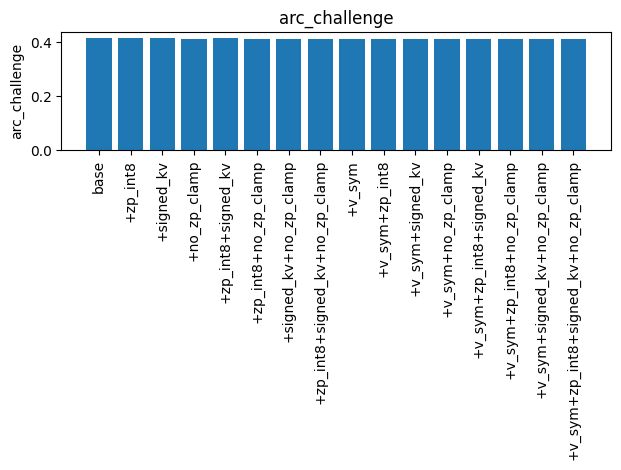

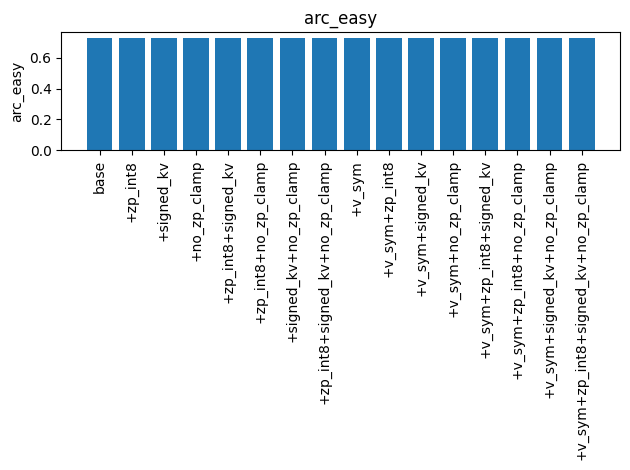

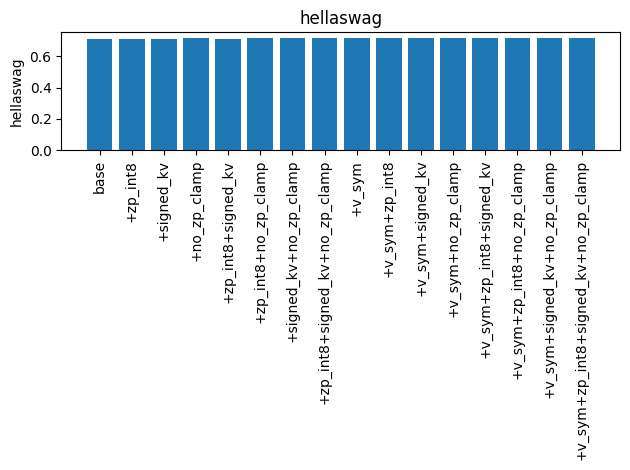

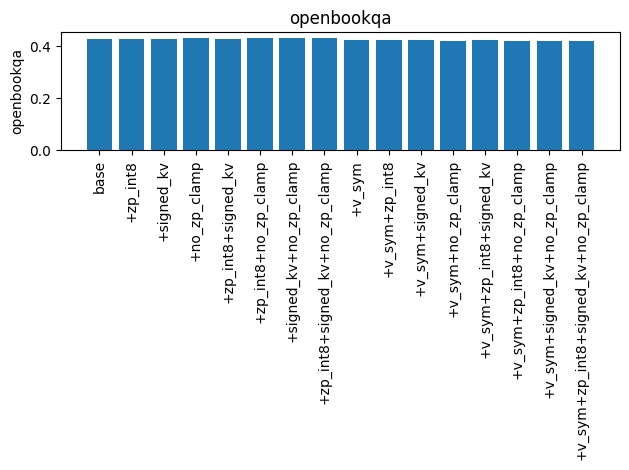

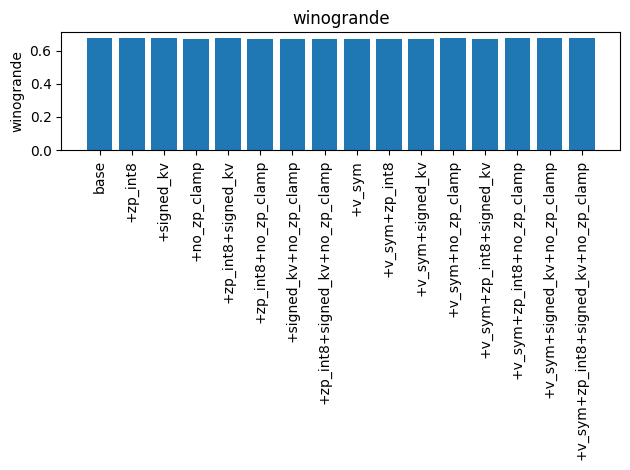

In [8]:
configs = list(results.keys())
metrics = list(next(iter(results.values())).keys())

# Plot one bar chart per metric
for metric in metrics:
    values = [results[config][metric] for config in configs]
    plt.figure()
    plt.bar(configs, values)
    plt.ylabel(metric)
    plt.xticks(rotation=90)
    plt.title(metric)
    plt.tight_layout()
    plt.show()